<a href="https://colab.research.google.com/github/Broken1412Heart/demo/blob/main/Card_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 29.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise
import scipy.optimize
import tensorflow as tf
import tensorflow_addons as tfa
import time

from sklearn.metrics import mean_absolute_error as MAE
from skimage.metrics import peak_signal_noise_ratio as PSNR

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Heat

In [4]:
def discrete_heat_equation(u,dt=0.1,T=10):    
    h, w = u.shape
    img = u.copy()
    t = 0
    while(t < T):
        # x1 có size b?ng ?nh và = (?nh b? biên trái, thêm biên ph?i là biên ph?i ban d?u)
        x1 = np.hstack((img[:, 1:w], np.expand_dims(img[:,w-1], axis=1)))
        # x2 có size b?ng ?nh và = (?nh - b? biên ph?i, thêm biên trái là biên trái ban d?u)
        x2 = np.hstack((np.expand_dims(img[:,0], axis=1), img[:, 0:w-1]))
        # y1 có size b?ng ?nh và = (?nh - b? biên trên, thêm biên du?i là biên du?i ban d?u )
        y1 = np.vstack((img[1:h,:], img[h-1,:]))
        # y1 có size b?ng ?nh và = (?nh - b? biên du?i, thêm biên trên là biên trên ban d?u )
        y2 = np.vstack((img[0,:], img[0:h-1, :]))
        uxx = x1 - 2*img + x2
        uyy = y1 - 2*img + y2
        L = uxx + uyy
        img = img + dt*L
        t += 1
    return img

# Perona Malik

In [5]:
def PeronaMalik_Smoother(image,K,LAMBDA,gfunction,nIterations,convert_to_grayscale=True):
    """
    Smoothes the input image using the Perona-Malik anisotropic diffusion method from:
    http://image.diku.dk/imagecanon/material/PeronaMalik1990.pdf
    This method preserves edges while smoothing non-edge regions. 
    I.e. inter-region blurring is minimized while intra-region blurring is encouraged.
    
    image: the input image
    
    K: parameter for diffusion sensitivity. Could set this manually, or determine by Canny noise estimator histogram.
    
    LAMBDA: parameter for diffusion sensitivity. Should be 0 < LAMBDA < 1/4
    
    gfunction: 'Exponential' or 'Cauchy'. The function to use for calculating diffusion coefficients.
    These 2 functions are used in the original paper, but you can implement custom functions as well.
    
    nIterations: number of iterations to perform (more iterations -> more blurring). 
    Images of all iterations are saved in an array for viewing.
    
    convert_to_grayscale: True or False. If True, converts a color image to grayscale.
    If False, applies diffusion independently to each color channel.
    """
    
    #Print out shape so user can decide if it has the right number of color channels, etc.
    #E.g. to let user know if there are 4 channels (if not expecting alpha)
    print ('Image shape: '), image.shape

    #Optionally convert multichannel image to grayscale (if RGBA, will also average over A, so this is why shape is printed above)    
    #If the image is already 2 dimensional, is already assumed grayscale, so warn user.
    if convert_to_grayscale == True:
        try:
            image = np.mean(image,axis=2)
        except IndexError:
            raise IndexError('Image is already 2D, so is assumed grayscale already. Check shape.')

    
    #Get number of color channels of image [1 for grayscale, 3 for RGB, 4 for RGBA]
    #Assuming the image shape is heigth x width for grayscale,
    #or heigth x width x Nchannels for color. But not expecting more than 3 dimensions.
    nChannels = 1 if image.ndim == 2 else image.shape[2]
    print('nChannels',nChannels)
    
    #In the case of a grayscale image, to make things easier later, just make the grayscale image have a 3rd axis of length 1
    if nChannels == 1:
        image = np.expand_dims(image,axis=2)
    
    #4D Container array of all iterations of image diffusion
    image_stack = np.expand_dims(image,axis=0)
    #Do nIterations of diffusion:
    for i in range(nIterations):
        if i % 10 == 0:
            print('Starting iteration {0} of {1}'.format(i,nIterations))
        image_t = np.zeros(image.shape)
        for channel in range(nChannels):
            temp = image_stack[-1][:,:,channel]
            
            #Following equation 8 in paper: calculate nearest neighbor differences to approximate gradient of image intensity
            vert_diff = np.diff(temp,axis=0)
            horiz_diff = np.diff(temp,axis=1)
            nanrow = np.expand_dims(np.nan*np.ones(vert_diff.shape[1]),axis=0)
            nancol = np.expand_dims(np.nan*np.ones(horiz_diff.shape[0]),axis=0).T
            grad_S = np.vstack((vert_diff,nanrow)) #NaN on bottom row
            grad_N = np.vstack((nanrow,-vert_diff)) #NaN on top row, and negated diffs since going opposite direction from np.diff() default
            grad_E = np.hstack((horiz_diff,nancol)) #NaN on right column
            grad_W = np.hstack((nancol,-horiz_diff)) #NaN on left column, and negated diffs since going opposite direction from np.diff() default
            
            #Following equation 10 in paper: calculate conduction coefficients
            #Technically, the coefficients should be more appropriately be evaluated at the halfway point between pixels, not at the pixels themselves.
            #But this is more complicated for approximately same results (according to authors). So use the same values for gradients as above.
            if gfunction == 'Exponential':
                c_S = np.exp(-(grad_S/K)**2)
                c_N = np.exp(-(grad_N/K)**2)
                c_E = np.exp(-(grad_E/K)**2)
                c_W = np.exp(-(grad_W/K)**2)
                
            if gfunction == 'Cauchy':
                c_S = 1./(1.+(grad_S/K)**2)
                c_N = 1./(1.+(grad_N/K)**2)
                c_E = 1./(1.+(grad_E/K)**2)
                c_W = 1./(1.+(grad_W/K)**2)
            
            #Examine the conduction coefficients:
            '''if i == 7:
                plt.figure()
                plt.title('c_S Diffusion Coefficients\nChannel {}'.format(channel),fontsize=30)
                plt.tick_params(labelsize=0)
                plt.imshow(c_S,interpolation='none')
                cb=plt.colorbar()
                cb.ax.tick_params(labelsize=20) 
                plt.show()
#                print np.nanmin(c_S), np.nanmax(c_S), np.nanmean(c_S)
#                print c_S   '''         
            
            
            #Following equation 7 in paper: Update the image using the diffusion equation:
            temp2 = temp + LAMBDA*(c_S*grad_S + c_N*grad_N + c_E*grad_E + c_W*grad_W)
            
            #Reset boundaries since the paper uses adiabatic boundary conditions and above steps intentionally set boudnaries to NaNs
            temp2[:,0] = temp[:,0] #Left edge
            temp2[:,-1] = temp[:,-1] #Right edge
            temp2[-1,:] = temp[-1,:] #Bottom edge
            temp2[0,:] = temp[0,:] #Top edge
            
            #Update this channel of the image at this time step
            image_t[:,:,channel] = temp2
        image_t = np.expand_dims(image_t,axis=0)
        image_stack = np.append(image_stack,image_t,axis=0)    
    
    
    #image_stack is stack of all iterations.
    #iteration 0 is original image, iteration -1 is final image.
    #Intermediate images are also returned for visualization and diagnostics
    return image_stack[-1][:,:,0]

# PINN

In [6]:
def fun_u_0(img):
    u_0 = (img).flatten()
    return u_0.reshape(-1,1).astype("float32")

def concat_itself(arr, num, axis=0):
    res = arr
    for i in range(num-1):
        res = np.concatenate([res, arr], axis=axis)
    return res

def train_PINN(img, save_model_path, retrain=False, mode='TFoptimizer', N=5000):
    DTYPE = 'float32'
    xspace = np.linspace(0,img.shape[1]-1,img.shape[1])
    yspace = np.linspace(0,img.shape[0]-1,img.shape[0])
    T = np.zeros((img.shape[0]*img.shape[1],1)).astype(DTYPE)

    X, Y = np.meshgrid(xspace, yspace)
    X = X.reshape(-1,1).astype(DTYPE)
    Y = Y.reshape(-1,1).astype(DTYPE)
    # Các v? trí di?m ?nh ?ng v?i t = 0
    XY_0 = tf.concat([X, Y, T],axis=1)

    tspace = np.linspace(0.1, 1, 10)
    Xr, Yr, Tr = np.meshgrid(xspace, yspace, tspace)

    Xr = Xr.flatten().reshape(-1,1)
    Yr = Yr.flatten().reshape(-1,1)
    Tr = Tr.flatten().reshape(-1,1)
    # Các v? trí di?m ?nh tuong ?ng v?i t = 0.1, 0.2,...1
    XY_r = tf.cast(np.vstack([Xr.flatten(), Yr.flatten(), Tr.flatten()]).T, DTYPE)

    # Giá tr? di?m ?nh c?a b?c ?nh ban d?u
    u_0 = fun_u_0(img)

    XY_data = [XY_0]
    u_data = [u_0]

    # Initialize model
    model = None

    if retrain:
      model = tf.keras.models.load_model(save_model_path)
    else:
      model = PINN_NeuralNet()
      model.build(input_shape=(None,3))

    solver = PINNSolver(model, XY_r)

    # Start timer
    t0 = time.time()

    if mode == 'TFoptimizer':
        # Choose optimizer
        lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,20000],[1e-2,1e-3,5e-4,1e-5])
        optim = tf.keras.optimizers.Adam(learning_rate=lr)
        solver.solve_with_TFoptimizer(optim, save_model_path, X=XY_data, u=u_data, N=N)
        
    elif mode == 'ScipyOptimizer':
        solver.solve_with_ScipyOptimizer(XY_data, u_data,
                                method='L-BFGS-B',
                                options={'maxiter': 1000,
                                        'maxfun': 1000,
                                        'maxcor': 10,
                                        'maxls': 10,
                                        'ftol': 1e-10}       
                                )

    # Print computation time
    print('\nComputation time: {} seconds'.format(time.time()-t0))

    return X, Y

def predict_PINN(img, save_model_path, X, Y):
    DTYPE = 'float32'
    T_pre = np.ones((img.shape[0]*img.shape[1],1)).astype(DTYPE)
    # Các v? trí di?m ?nh ?ng v?i t = 0
    model_predict = tf.keras.models.load_model(save_model_path)
    XY_pre = tf.concat([X, Y, T_pre], axis=1)
    upred = model_predict(XY_pre).numpy().reshape(img.shape[0],img.shape[1])
    
    return upred

class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
            output_dim=1,
            num_hidden_layers=8, 
            num_neurons_per_layer=20,
            activation=tfa.activations.mish,
            kernel_initializer='glorot_uniform',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        #self.lb = lb
        #self.ub = ub
        
        # Define NN architecture
        #self.scale = tf.keras.layers.Lambda(
        
        #   lambda x: 1.0*(x - lb)/(ub - lb))
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    def call(self, X):
        """Forward-pass through neural network."""
        #Z = self.scale(X)
        Z = X
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        
        # Store collocation points
        self.x = X_r[:,0:1]
        self.y = X_r[:,1:2]
        self.t = X_r[:,2:3]
        
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            
            tape.watch(self.x)
            tape.watch(self.y)
            tape.watch(self.t)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.x[:,0], self.y[:,0], self.t[:,0]], axis=1))
            u_x = tape.gradient(u, self.x)
            u_y = tape.gradient(u, self.y)
            c = self.g_cauchy(k = 0.1, u=(u_x*u_x+u_y*u_y)) #dolon_graient_u_2 = (u_x*u_x + u_y*u_y)
        u_xy = tape.gradient(u_x, self.y)
        c_x = tape.gradient(c, self.x)
        c_y = tape.gradient(c, self.y)
        u_t = tape.gradient(u, self.t)  
        u_xx = tape.gradient(u_x, self.x)
        u_yy = tape.gradient(u_y, self.y)
        
        del tape
        
        return self.fun_r(u_t, u_xx, u_yy, u_x, u_y, c_x, c_y, c, u_xy)
    
    def loss_fn(self, X, u):
        
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))
        
        return loss
    
    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
     #da sua ham cho dung
    def fun_r(self,u_t, u_xx, u_yy, u_x, u_y, c_x, c_y, c, u_xy):
        dolon_graient_u_2 = (u_x*u_x + u_y*u_y)

        return -u_t + c*(u_x*u_x*u_yy - 2*u_x*u_y*u_xy + u_y*u_y*u_xx)/dolon_graient_u_2 + (c + 2*dolon_graient_u_2*self.g_cauchy_dt(0.1, u=dolon_graient_u_2))*(u_x*u_x*u_xx + 2*u_x*u_y*u_xy + u_y*u_y*u_yy)/dolon_graient_u_2

   
    
    def g_cauchy(self, k, u):
        return 1/(1+((u*u)/(k*k)))

    def g_cauchy_dt(self, k, u):
        top = -2*u / (k*k)
        bot = (1+(u*u / k*k))*(1+(u*u / k*k))
        return top / bot

    def solve_with_TFoptimizer(self, optimizer, model_path, X, u, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback(model_path)

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            DTYPE = 'float32'
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)
            
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, model_path, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))

        if self.iter % 100 == 0:
            self.model.save(model_path)
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

# Train

In [11]:
def train(img_path, save_model_path, dt=0.05, T=5, nIterations=100, N=5000, PINN_mode='TFoptimizer', retrain=False):
  img = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (100, 100))

  noise_img = random_noise(img,mode="gaussian",var = VAR)

  img_heat = discrete_heat_equation(noise_img,dt=0.05,T=T)

  img_pm = PeronaMalik_Smoother(noise_img, 20, 0.05,gfunction='Exponential', nIterations=nIterations, convert_to_grayscale=False)
  
  X, Y = train_PINN(noise_img, save_model_path, mode=PINN_mode, N=N)
  PINN_result = predict_PINN(img, save_model_path, X, Y)

  imgs = [img, noise_img, img_heat, img_pm, PINN_result]
  titles = ['Origin', 'Noise', 'Heat', 'Perona Malik', 'PINN']

  fig, ax = plt.subplots(1, 5, figsize=(20, 20))

  for i in range(len(imgs)):
    ax[i].set_axis_off()
    ax[i].imshow(imgs[i], 'gray')
    ax[i].set_title(titles[i])

    if i > 1:
      true_img = img / 255
      mae = MAE(true_img, imgs[i].astype('float64'))
      psnr = PSNR(true_img, imgs[i].astype('float64'))


      print(f"{titles[i]}'s MAE: {mae}")
      print(f"{titles[i]}'s PSNR: {psnr}")
      print()
  fig.savefig(f'{save_model_path}/plot.png')

## CARD


Image shape: 
nChannels 1
Starting iteration 0 of 100
Starting iteration 10 of 100
Starting iteration 20 of 100
Starting iteration 30 of 100
Starting iteration 40 of 100
Starting iteration 50 of 100
Starting iteration 60 of 100
Starting iteration 70 of 100
Starting iteration 80 of 100
Starting iteration 90 of 100


It 00000: loss = 4.18012828e-01
It 00050: loss = 4.62940112e-02
It 00100: loss = 4.31414992e-02
It 00150: loss = 3.95696238e-02
It 00200: loss = 3.86226773e-02
It 00250: loss = 3.60503010e-02
It 00300: loss = 3.70851494e-02
It 00350: loss = 3.31455395e-02
It 00400: loss = 3.24838869e-02
It 00450: loss = 2.98288576e-02
It 00500: loss = 2.90500168e-02
It 00550: loss = 2.80580949e-02
It 00600: loss = 2.79748198e-02
It 00650: loss = 2.79465783e-02
It 00700: loss = 2.56523751e-02
It 00750: loss = 2.52045244e-02
It 00800: loss = 2.56730095e-02
It 00850: loss = 2.48395652e-02
It 00900: loss = 2.50019915e-02
It 00950: loss = 2.39360072e-02
It 01000: loss = 2.49301549e-02
It 01050: loss = 2.34935414e-02
It 01100: loss = 2.34375913e-02
It 01150: loss = 2.33896617e-02
It 01200: loss = 2.33441517e-02
It 01250: loss = 2.32996978e-02
It 01300: loss = 2.32555252e-02
It 01350: loss = 2.32111048e-02
It 01400: loss = 2.31660083e-02
It 01450: loss = 2.31197961e-02
It 01500: loss = 2.30718758e-02
It 01550

Heat's MAE: 0.05595908528282388
Heat's PSNR: 22.900846481294153

Perona Malik's MAE: 0.09210844327203573
Perona Malik's PSNR: 17.906756214194562

PINN's MAE: 0.06284724597945664
PINN's PSNR: 20.632955497516182



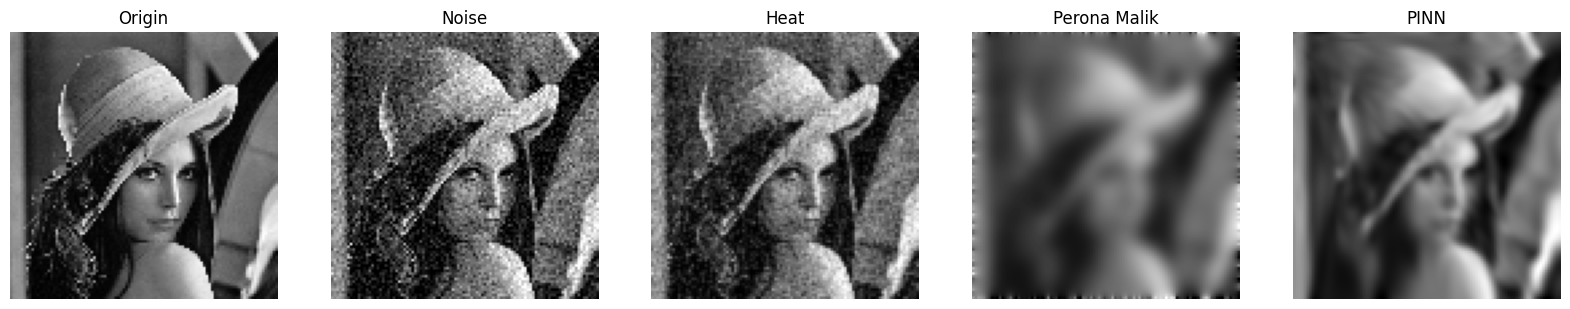

In [26]:
img = '/content/drive/MyDrive/Colab/KLTN/img/lena.png'
save_model_path = '/content/drive/MyDrive/Colab/KLTN/model/KQ_001'
VAR = 0.01
T = 2
nIterations = 100
N = 30000

train(img, save_model_path, T=T, nIterations=nIterations, N=N, retrain=True)